In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

# Prepare Data

In [68]:

# LOAD DATA MERGE AND CLEAN
dir_name = "05_ComicBook"
anime = pd.read_csv(f"{dir_name}/anime.csv")
rating = pd.read_csv(f"{dir_name}/rating.csv")

data = pd.merge(rating, anime, on='anime_id')
data.rename(columns={'rating_x': 'user_rating', 'rating_y': 'anime_rating'}, inplace=True)
data.dropna(inplace=True)
data = data[data['user_rating'] != -1]

# ADD IMPORTANCE 
# normalize user_rating by user mean and max rating


# remove user with less than 10 ratings no important information can be extracted
data = data.groupby('user_id').filter(lambda x: len(x) >= 10)

user_stats = data.groupby('user_id')['user_rating'].agg(['mean', 'max']).rename(columns={'mean': 'mean_rating', 'max': 'max_rating'})
data = data.merge(user_stats, on='user_id')

def normalize_rating(row):
    if row['user_rating'] < row['mean_rating']:
        if row['mean_rating'] == 0:
            return -1
        if -1 * (row['mean_rating'] - row['user_rating']) / row['mean_rating'] > 0 :
            print("ERROR")
        return -1 * (row['mean_rating'] - row['user_rating']) / row['mean_rating']
    else:
        if row['max_rating'] == row['mean_rating']: 
            return 0
        return (row['user_rating'] - row['mean_rating']) / (row['max_rating'] - row['mean_rating'])

data['importance'] = data.apply(normalize_rating, axis=1)

# remove anime_rating, remove members, remove type, remove max_rating
data.drop(columns=['anime_rating', 'members', 'type', 'max_rating', 'mean_rating'], inplace=True)

data.head()



,user_id,anime_id,user_rating,name,genre,episodes,importance
0,3,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",220,0.178571
1,3,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",12,-0.206897
2,3,9919,8,Ao no Exorcist,"Action, Demons, Fantasy, Shounen, Supernatural",25,0.178571
3,3,11737,7,Ao no Exorcist Movie,"Action, Demons, Fantasy, Shounen, Supernatural",1,-0.074713
4,3,11757,9,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",25,0.589286


Number of users: 55118
Number of animes: 9891


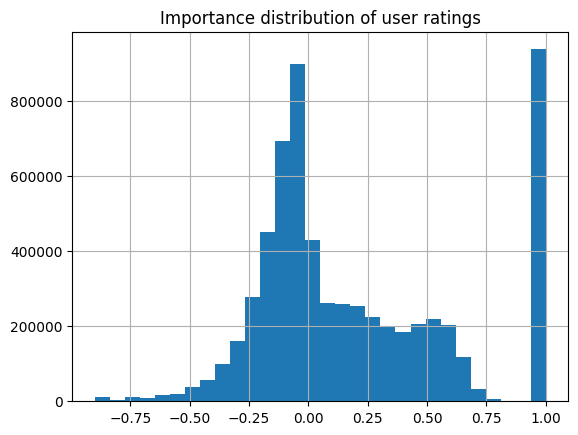

In [3]:
# print number of unique users and animes
n_users = data['user_id'].nunique()
n_animes = data['anime_id'].nunique()
print(f"Number of users: {n_users}")
print(f"Number of animes: {n_animes}")

# print the importance distribution of user ratings
data['importance'].hist(bins=30)
plt.title("Importance distribution of user ratings")
plt.show()



In [16]:

# Preparazione dei dati
user_anime_matrix = data.pivot_table(index='user_id', columns='anime_id', values='importance').fillna(0)

# get 5% of the users as test users
user_id_test = user_anime_matrix.sample(frac=0.05, random_state=42).index

print("Total users:", len(user_anime_matrix), "      Test users:", len(user_id_test) )


# Soglia di 'high importance'
high_importance_threshold = 0.5

# Inizializzazione della matrice anime-anime con float per la somma delle importanze
anime_anime_matrix = pd.DataFrame(0.0, index=user_anime_matrix.columns, columns=user_anime_matrix.columns, dtype=float)

# Inizializzazione della matrice per il conteggio dei voti
anime_vote_count_matrix = pd.DataFrame(0, index=user_anime_matrix.columns, columns=user_anime_matrix.columns, dtype=int)

# Progress bar setup
total_to_compute = len(user_anime_matrix.columns)
pbar = tqdm(total=total_to_compute, desc="Processing Anime")

# Calcolo della somma delle importanze e conteggio dei voti
for anime_id in user_anime_matrix.columns:
    # Ottenere utenti con alta importance escludendo i test users
    high_importance_users = user_anime_matrix[(user_anime_matrix[anime_id] > high_importance_threshold) & (~user_anime_matrix.index.isin(user_id_test))]

    # Somma dei vettori degli anime valutati da questi utenti
    anime_vectors_sum = high_importance_users.sum(axis=0)
    anime_anime_matrix.loc[anime_id] = anime_vectors_sum
    
    # Conteggio dei voti per ogni anime valutato dagli utenti
    anime_vote_counts = high_importance_users.astype(bool).sum(axis=0)
    anime_vote_count_matrix.loc[anime_id] = anime_vote_counts

    # Update progress bar
    pbar.update(1)

# Close progress bar
pbar.close()

# Output delle matrici
print("Anime-Anime Similarity Matrix:")
print(anime_anime_matrix)
print("\nAnime-Anime Vote Count Matrix:")
print(anime_vote_count_matrix)

Total users: 55118       Test users: 2756


Processing Anime:   0%|          | 0/9891 [00:00<?, ?it/s]

Anime-Anime Similarity Matrix:
anime_id        1            5            6           7          8      \
anime_id                                                                 
1         6175.350417  1689.822568  1470.213684   76.992924  -1.234820   
5         1620.778177  1672.812829   517.971650   45.386116   2.486776   
6         1402.577513   522.733755  2618.943487   57.845916   1.748146   
7          100.169325    52.860971    73.069094  220.667324   1.133564   
8            5.476855     3.203855     5.907215    1.919889  27.678388   
...               ...          ...          ...         ...        ...   
34324        0.000000     0.000000     0.000000    0.000000   0.000000   
34325        0.000000     0.000000     0.000000    0.000000   0.000000   
34349        0.000000     0.000000     0.000000    0.000000   0.000000   
34367        0.000000     0.000000     0.000000    0.000000   0.000000   
34475        0.000000     0.000000     0.000000    0.000000   0.000000   

anime_

In [66]:
# set 0 on the diagonal
np.fill_diagonal(anime_anime_matrix.values, 0)

# print nuber of person that have importance 1 on anime 138
print("Number of person that have importance 1 on anime 138:", len(user_anime_matrix[user_anime_matrix[138] == 1]))


Number of person that have importance 1 on anime 138: 485


In [89]:
# save the matrix for future use
anime_anime_matrix.to_csv(f"{dir_name}/anime_anime_matrix.csv")

Anime name of most 10 similar animes to anime hunter X hunter
1         Fullmetal Alchemist: Brotherhood
6                   Hunter x Hunter (2011)
13      Code Geass: Hangyaku no Lelouch R2
19         Code Geass: Hangyaku no Lelouch
40                              Death Note
112                        Hunter x Hunter
145                    Hunter x Hunter OVA
146    Hunter x Hunter: Greed Island Final
Name: name, dtype: object
Number of users that have seen the anime: 485
Mean rating of the users: 9.61921965317919


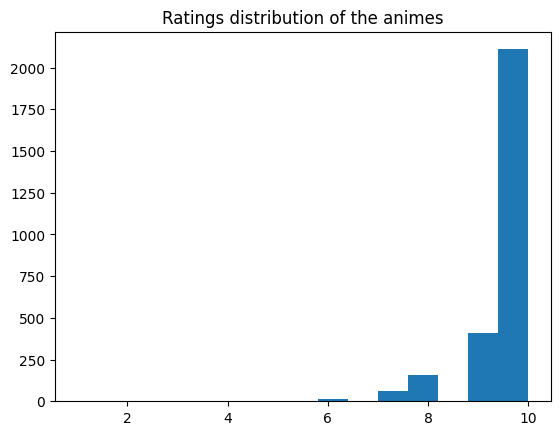

Anime name of most 10 similar animes to anime hunter X hunter
15                      Sen to Chihiro no Kamikakushi
22                                       Cowboy Bebop
24                                      Mononoke Hime
28                                           Mushishi
29                         Tengen Toppa Gurren Lagann
84                                           Baccano!
130    Neon Genesis Evangelion: The End of Evangelion
211                           Neon Genesis Evangelion
Name: name, dtype: object
Number of users that have seen the anime: 179
Mean rating of the users: 8.840277777777779


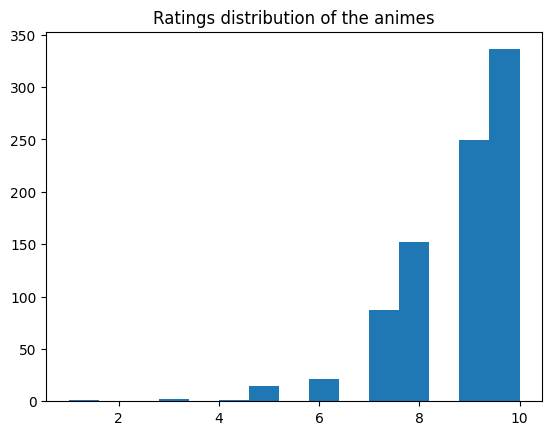

In [78]:


def test_single_anime(anime_id):
    similarities = anime_anime_matrix.loc[anime_id]
    most_similar_animes = similarities.sort_values(ascending=False).drop(index=anime_id)

    print("Anime name of most 10 similar animes to anime" + anime[anime['anime_id'] == anime_id]['name'].values[0])
    print(anime[anime['anime_id'].isin(most_similar_animes.head(8).index)]['name'])

    users = user_anime_matrix[user_anime_matrix[anime_id] > 0.9].index
    print(f"Number of users that have seen the anime: {len(users)}")
    anime_ids = most_similar_animes.head(8).index
    mean_importance = 0
    counter = 0
    ratings = []
    importance = []
    for user in users:
        for anime_id in anime_ids:
            if user_anime_matrix.loc[user, anime_id] != 0:
                mean_importance += user_anime_matrix.loc[user, anime_id]
                ratings.append(data[(data['user_id'] == user) & (data['anime_id'] == anime_id)]['user_rating'].values[0])
                importance.append(anime_anime_matrix.loc[813, anime_id])
                counter += 1

    print(f"Mean rating of the users: {np.mean(ratings)}")

    plt.hist(ratings, bins=15)
    plt.title("Ratings distribution of the animes")
    plt.show()

# one of the most famous anime hunter x hunter
anime_id = 138
test_single_anime(anime_id)


# a specific anime loved only by a few users is Kaiba from maasaky yuasa
anime_id = 3701
test_single_anime(anime_id)





In [82]:
from collections import Counter


def recommend_top_animes(anime_list, X, K, similarity_matrix):
    recommendation_counts = Counter()

    for anime_id in anime_list:
        if anime_id in similarity_matrix.index:
            most_similar = similarity_matrix.loc[anime_id].drop(index=anime_id).nlargest(X).index.tolist()
            recommendation_counts.update(most_similar)

    # remove element present in the input list
    for anime_id in anime_list:
        recommendation_counts.pop(anime_id, None)
    
    top_recommended_animes = [anime for anime, _ in recommendation_counts.most_common(K)]
    
    return top_recommended_animes

X = 15  
K = 10  

# test with sone anime
# evangelion, tatami galaxy, kaiba, paprika, perfect blue
anime_list = [30, 8985, 3701, 1943, 437]

top_animes_recommended = recommend_top_animes(anime_list, X, K, anime_anime_matrix)
# print name of the top 10 recommended animes
print(anime[anime['anime_id'].isin(top_animes_recommended)]['name'])




1                    Fullmetal Alchemist: Brotherhood
3                                         Steins;Gate
15                      Sen to Chihiro no Kamikakushi
22                                       Cowboy Bebop
24                                      Mononoke Hime
29                         Tengen Toppa Gurren Lagann
40                                         Death Note
96                         Mahou Shoujo Madoka★Magica
130    Neon Genesis Evangelion: The End of Evangelion
132                             Toki wo Kakeru Shoujo
Name: name, dtype: object


In [95]:

def adjusted_user_mean(user_id, X):
    excluded_animes = user_anime_matrix.loc[user_id].nlargest(X).index.tolist()
    user_ratings = data[data['user_id'] == user_id]
    filtered_ratings = user_ratings[~user_ratings['anime_id'].isin(excluded_animes)]
    
    mean_rating = filtered_ratings['user_rating'].mean()
    
    return mean_rating

total_rating_1 = 0
counter_1 = 0

pbar = tqdm(total=len(user_id_test), desc="Processing Test Users")


for user_id in user_id_test:


    anime_list = user_anime_matrix.loc[user_id].nlargest(10).index.tolist()
    top_animes_recommended = recommend_top_animes(anime_list, X, K, anime_anime_matrix)

    total_rating_2 = 0
    counter_2 = 0
    for user in [user_id]:
        for anime_id in top_animes_recommended:
            if user_anime_matrix.loc[user, anime_id] != 0:
                rating = data[(data['user_id'] == user) & (data['anime_id'] == anime_id)]['user_rating'].values[0]
                total_rating_2 += rating
                counter_2 += 1


    pbar.update(1)

    if counter_2 == 0:
        continue
    
    total_rating_1 += total_rating_2/counter_2
    counter_1 += 1


print(f"Mean rating for all test users: {total_rating_1 / counter_1}")


# mean user test rating using adjusted_user_mean (we exclude the top X animes because system can't recommend them)
mean = 0
counter = 0
for user_id in user_id_test:
    mean += adjusted_user_mean(user_id, X)
    counter += 1

print(f"Mean vote for all test users using adjusted_user_mean: {mean / counter}")

Processing Test Users:   0%|          | 0/2756 [00:00<?, ?it/s]

Mean rating for all test users: 8.345381977586877
Mean vote for all test users using adjusted_user_mean: 7.53722421043975


In [99]:
# get the mean over top X anime for test user that are not in the top X anime

def top_algoritm_comparison(user_id, X):
    user_ratings = data[data['user_id'] == user_id]
    sorted_ratings = user_ratings.sort_values(by='user_rating', ascending=False)
    excluded_top_x = sorted_ratings.iloc[X:]
    
    next_best_x = excluded_top_x.head(X)
    
    improved_mean_rating = next_best_x['user_rating'].mean()
    
    return improved_mean_rating

mean = 0
counter = 0
for user_id in user_id_test:
    mean_tmp = top_algoritm_comparison(user_id, X)
    if not np.isnan(mean_tmp):
        mean += mean_tmp
        counter += 1

print(f"Perfect teroretical prediction on X anime with max score for user: {mean / counter}")

# get the mean over top 1 anime for test user that are not in the top X anime

def top_algoritm_comparison2(user_id, X):
    user_ratings = data[data['user_id'] == user_id]
    sorted_ratings = user_ratings.sort_values(by='user_rating', ascending=False)
    excluded_top_x = sorted_ratings.iloc[X:]
    
    next_best_x = excluded_top_x.head(1)
    
    improved_mean_rating = next_best_x['user_rating'].mean()
    
    return improved_mean_rating

mean = 0
counter = 0
for user_id in user_id_test:
    mean_tmp = top_algoritm_comparison2(user_id, X)
    if not np.isnan(mean_tmp):
        mean += mean_tmp
        counter += 1

print(f"Perfect teroretical prediction only 1 anime with max score for user: {mean / counter}")




Mean vote for all test users using top_algoritm_comparison: 8.551793887231469
Mean vote for all test users using top_algoritm_comparison: 8.95102368526696
